In [1]:
import os
import pandas as pd
from pathlib import Path
from urllib.request import urlretrieve
from risparser import convert_ris_to_csv

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Retrieve RIS files and convert to CSV

In [2]:
# retrieve RIS files from OSF
url_full = "https://osf.io/a26sz/download"
url_included = "https://osf.io/hy8qe/download"
os.makedirs("raw", exist_ok=True)
urlretrieve(url_full, "raw/dataset_full.ris")
urlretrieve(url_included, "raw/dataset_included.ris")

('raw/dataset_included.ris', <http.client.HTTPMessage at 0x117d0c0d0>)

In [3]:
# convert to CSV
convert_ris_to_csv("raw/dataset_full.ris", "csv/dataset_full.csv")
convert_ris_to_csv("raw/dataset_included.ris", "csv/dataset_included.csv")

Input file: raw/dataset_full.ris
Number of articles: 5019
Export file: csv/dataset_full.csv
Input file: raw/dataset_included.ris
Number of articles: 19
Export file: csv/dataset_included.csv


## Clean datasets

In [4]:
# read csv files
df_all = pd.read_csv("csv/dataset_full.csv", usecols=["title", "abstract", "keywords", "authors", "year", "doi"])
df_included = pd.read_csv("csv/dataset_included.csv", usecols=["title", "abstract", "keywords", "authors", "year", "doi"])

In [5]:
# add label
df_all["label_included"] = 0
df_included["label_included"] = 1

In [6]:
# merge datasets
df_merged = df_included.append(df_all, sort=False)

In [7]:
# remove duplicates
df_title = df_merged["title"].str.replace("[^A-Za-z0-9]", "", regex=True)
df_merged = df_merged[(~df_title.str.lower().duplicated()) | (df_title.isnull())]

## Export datasets

In [8]:
Path("output").mkdir(parents=True, exist_ok=True)
df_merged.to_csv("output/Wolters_2018.csv", index=False)

## Dataset statistics

In [9]:
n = len(df_merged)
n_inc = df_merged["label_included"].sum()
n_exc = n - n_inc

print("Number of papers with missing title:    ", df_merged["title"].isna().sum(), "\n")
print("Number of papers with missing abstract: ", df_merged["abstract"].isna().sum(), "\n")
print("Number of papers with missing title AND abstract: ", (df_merged['title'].isna() & df_merged["abstract"].isna()).sum(), "\n")
print("Number of papers with missing title OR abstract:  ", (df_merged['title'].isna() | df_merged["abstract"].isna()).sum(), "\n\n")

print("Total number of papers:                 ", n, "\n")
print("Total number of EXCLUSIONS:             ", n_exc, "\n")
print("Total number of INCLUSIONS:             ", n_inc, " (", round(100*n_inc/n, 2), "% )\n")

Number of papers with missing title:     5 

Number of papers with missing abstract:  789 

Number of papers with missing title AND abstract:  0 

Number of papers with missing title OR abstract:   794 


Total number of papers:                  4833 

Total number of EXCLUSIONS:              4814 

Total number of INCLUSIONS:              19  ( 0.39 % )



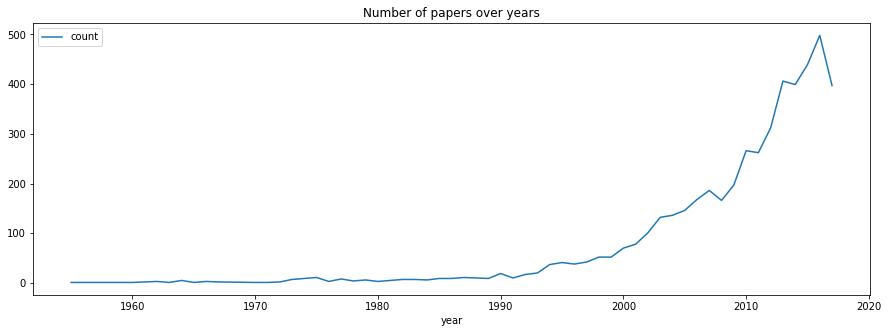

In [10]:
# number of papers over years
df_merged.groupby("year").size().reset_index(name="count").set_index("year").plot(figsize=(15,5))
plt.title("Number of papers over years")
plt.show()

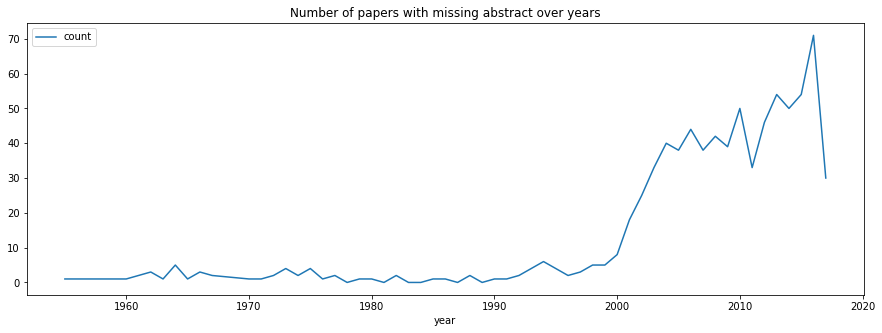

In [11]:
# missing abstract over years
df_merged["abstract"].isna().groupby(df_merged["year"]).sum().astype(int).\
reset_index(name="count").set_index("year").\
plot(figsize=(15,5))
plt.title("Number of papers with missing abstract over years")
plt.show()

There are 460249 words in the combination of all titles. 

There are 6651818 words in the combination of all abstracts. 



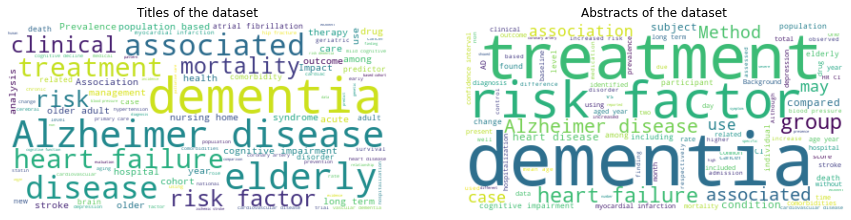

In [12]:
# word cloud for titles and abstracts
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update(["study", "patient", "patients", "effect", "effects", "result", "results", "conclusion", "conclusions"])

# create word cloud text
title_text = " ".join(word for word in df_merged.title.dropna())
abstract_text = " ".join(word for word in df_merged.abstract.dropna())
print("There are {} words in the combination of all titles.".format(len(title_text)), "\n")
print("There are {} words in the combination of all abstracts.".format(len(abstract_text)), "\n")

# generate word cloud images
title_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(title_text)
abstract_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(abstract_text)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 15])
ax1.imshow(title_wordcloud, interpolation="bilinear")
ax1.set_title("Titles of the dataset")
ax1.axis("off")
ax2.imshow(abstract_wordcloud, interpolation="bilinear")
ax2.set_title("Abstracts of the dataset")
ax2.axis("off")
plt.show()